### 原理
元算法（meta-algorithm）是对其它算法进行组合的一种方式
Adaboost是一种迭代算法，其核心思想是针对同一个训练集训练不同的分类器(弱分类器)，然后把这些弱分类器集合起来，构成一个更强的最终分类器（强分类器）。
Boosting，也称为增强学习或提升法，是一种元算法框架，而AdaBoost是其中最成功的代表。

AdaBoost为每个分类器都分配一个权重值alpha，alpha基于每个弱分类器的错误率进行计算。
$$\varepsilon=\frac{未正确分类的样本数目}{所有样本数目}$$
而alpha为
$$\alpha=\frac{1}{2}ln(\frac{1-\varepsilon}{\varepsilon})$$
计算出alpha后可以对权重向量D进行更新，以使得那些正确分类的样本的权重降低而错分样本的权重升高。

如果某个样本被正确分类，则其权重调整为$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{-\alpha}}{Sum(D)}$$
如果某个样本被错误分类，则其权重调整为$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{\alpha}}{Sum(D)}$$
计算出D后，AdaBoost进行下一次迭代。不断重复训练直至错误率为0或者弱分类器数目达到指定值。

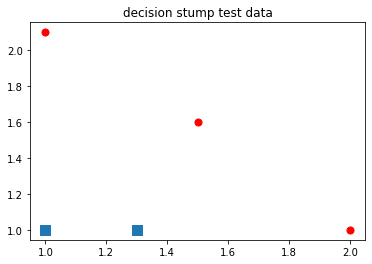

In [1]:
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
datMat = matrix([[ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]


xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []
markers =[]
colors =[]

for i in range(len(classLabels)):
    if classLabels[i]==1.0:
        xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
    else:
        xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
fig = plt.figure()
ax = fig.add_subplot(111)       
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('decision stump test data')
plt.show()


**对于以上的数据类型，很难选择一条与坐标轴平行的直线将两种数据点分开，这就意味着单层决策树很难处理，通过使用多棵单层决策树，我们就可以构建出一个很好的分类器。**

In [12]:
#单层决策树生成函数（弱分类算法）
#伪代码
#将最小错误率minError设为正无穷
#对数据集中的每一个特征（第一层循环）：
#    对每个步长（第二层循环）：
#        对每个不等号（第三层循环）：
#            建立一棵单层决策树并利用加权数据集对它进行测试
#            如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
#返回最佳单层决策树
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

#通过预祝比较对数据进行分类，在阈值一边的数据为类别-1，另外一边为+1
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = ones((shape(dataMatrix)[0],1))#将返回数组的全部元素设置为1
    if threshIneq == 'lt':#将不满足要求的设为-1
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):#传入数据、类别、权重向量
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #一开始初始化为无穷大 之后用于寻找可能的最小错误率
    for i in range(n):#在数据集的所有特征上变量
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();#获取最大值与最小值
        stepSize = (rangeMax-rangeMin)/numSteps#通过最大值与最小值计算步长
        for j in range(-1,int(numSteps)+1):#在这些值上遍历
            for inequal in ['lt', 'gt']: #在大于小于间切换不等号
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#调用函数，基于这些循环变量，函数会返回分类预测的结果
                errArr = mat(ones((m,1))) #将errArr全部初始化为1，也就是说全错
                errArr[predictedVals == labelMat] = 0  #如果说预测值与真实值相等，那么该位置对应的errArr就是0，也就是说该位置时对的
                weightedError = D.T*errArr  #c权重向量与错误向量相乘
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                #如果当前错误率比最小错误率小，则保存当前单层决策树
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

datMat,classLabels=loadSimpData()
D=mat(ones((5,1))/5)#权重向量
buildStump(datMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [14]:
#基于以上的基于加权输入值进行决策的分类器（弱分类器），我们可以实现一个完整AdaBoost算法(强分类器)
#伪代码
#对每次迭代：
#    利用buildStump（）函数找到最佳的单层决策树
#    将最佳单层决策树加入到单层决策树数组
#    计算alpha
#    计算新的权重向量D
#    更新累计类别估计向量
#    如果错误率等于0.0，则退出循环

#基于单层决策树的AdaBoost的训练过程
def adaBoostTrainDS(dataArr,classLabels,numIt=40):  #数据集、类别标签、迭代次数
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #D表示各个数据点的权重，它是一个概率分布向量，即其所有元素之和为0,开始初始化每个权重为1/m
    aggClassEst = mat(zeros((m,1)))#用于记录每个数据点的类别估计累计值
    for i in range(numIt):#循环会在错误率为0或者达到迭代次数时停止
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#创建单层决策树
        #print("D:",D.T)
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#alpha用于告诉总分类器本次单层决策树输出结果的权重，max（error，1e-16）用于确保不会发生除0溢出
        bestStump['alpha'] = alpha  #alpha值加入besttump字典
        weakClassArr.append(bestStump)                 # 字典加入列表，该字典包含分类所需的所有信息
        #print("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #用于计算下一次迭代的新权重向量D
        D = multiply(D,exp(expon))                              
        D = D/D.sum()
        aggClassEst += alpha*classEst
        #print("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))#由于aggClassEst是一个浮点数，，为了得到二值分类结果，调用sign函数
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break #总错误率为0 则终止for循环
    return weakClassArr,aggClassEst#权重值、类别估计值
classifierArray,aggClassEst=adaBoostTrainDS(datMat,classLabels,9)
classifierArray

total error:  0.2
total error:  0.2
total error:  0.0


[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

**AdaBoostTrainDS函数中DS代表单层决策树(decision stump)，它是AdaBoost中最流行的弱分类器。除此之外，其它的分类器都可以作为基分类器。**

**以上输出的数组包含三部字典，其中包含了分类所需的全部信息，分类器构建成功,而后我们将各个弱分类器的结果抽离出来，以其对应的alpha作为权重。所有这些弱分类器的结果加权求和得到最后结果。代码如下：**

In [19]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    print(classifierArr[1])
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq'])#
        aggClassEst += classifierArr[i]['alpha']*classEst#弱分类器结果加权求和得到结果
        print(aggClassEst)
    return sign(aggClassEst)
datArr,labelArr=loadSimpData()
classifierArr,aggClassEst=adaBoostTrainDS(datArr,labelArr,30)
print(adaClassify([0,0],classifierArr))#传入一个点时分类结果
print(adaClassify([[5,5],[0,0]],classifierArr))#传入两个点时分类结果

total error:  0.2
total error:  0.2
total error:  0.0
{'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}
[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]
[[-1.]]
{'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}
[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]
[[ 1.]
 [-1.]]


### 非均衡分类问题
通过错误率来来衡量分类器的成功程度。错误率指得是在所有测试样例中错分的样例比例。但这样度量错误掩盖了样例如何被错分的事实。通过混淆矩阵可以便于人们了解分类中的错误。以下是一个二类问题的混淆矩阵。

|  |   |预测结果|预测结果|
| ------ | ------ | ------ |------|
|  |  |+1 |-1|
| 真实结果 | +1 | 真正例（TP）|伪反例（FN）|
| 真实结果 | -1 | 伪正例（FP） |真反例（TN）|

我们期望混淆矩阵的非对角元素均为0，这时就会得到一个完美的分类器。

通过混淆矩阵，我们可以定义出比错误率更好的新指标，如：
* 正确率（Precision）=TP/(TP+FP) 预测为正例的样本中真正正例的比例
* 召回率（Recall）=TP/(TP+FN)  预测为正例的真实正例占所有真实正例的比例

除此之外，另一个用于度量分类中的非均衡性的工具是ROC曲线，ROC代表接受者操作特征（receiver operating characteristic）。可用于比较分类器，还可以基于成本效益（cost-versus-benefit）分析做出决策。在此不过多介绍ROC曲线，它的作用就是对分类器的效果做出评判。

处理非均匀分类代价问题的方法：
* 调节分类器的阈值
* 代价敏感的学习（cost-sensitive learing）
* 对分类器的训练数据进行改造。这可以通过欠抽样（undersampling）或者过抽样（oversampling）来实现。过抽样意味着复制样例，欠抽样意味着删除样例。

### 总结
两种集成方法bagging和boosting。在bagging中，是通过随机抽样的替换方式，得到了与原始数据集规模一样的数据集。而boosting在bagging的思路上更近一步，在数据集上顺序应用了多个不同的分类器。集成方法有随机森林和AdaBoosting等。而boosting方法中最流行的是AdaBoosting算法。
AdaBoost优缺点：
* 优点：泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整。
* 缺点：对离群点敏感。
* 适用数据类型：数值型和标称型数据。

AdaBoost算法流程
1. 先通过对N个训练样本的学习得到第一个弱分类器；
2. 将分错的样本和其他的新数据一起构成一个新的N个的训练样本，通过对这个样本的学习得到第二个弱分类器 ；
3. 将1和2都分错了的样本加上其他的新样本构成另一个新的N个的训练样本，通过对这个样本的学习得到第三个弱分类器；
4. 最终经过提升的强分类器。即某个数据被分为哪一类要由各分类器权值决定。

AdaBoost系列主要解决了: 两类问题、多类单标签问题、多类多标签问题、大类单标签问题、回归问题。它用全部的训练样本进行学习。